In [1]:
import numpy as np
from skimage import io
from pathlib import Path
import re
#import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_closing
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
#import skan
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
from RedLionfishDeconv import doRLDeconvolutionFromNpArrays

In [2]:
mouse_ids_path = Path('matt_raw_warped')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*res*.tif'))#grab folder names/mouse ids
mouse_ids = sorted([x.as_posix() for x in mouse_ids])
data_dicts = [
    {"image":image_name}
    for image_name in mouse_ids
]

#data_dicts = [data_dicts[_i]]
re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])

'matt_raw_warped/06162021_45-XYZres288_0001_warped.tif'

# Define connected componnet removal

In [19]:
def remove_small_comps_3d(image, thresh = 500*15):
    """
    

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=100*15):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

# register raw iamges

In [4]:
mouse_ids_path = Path('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*?[0-9]/*res*?[0-9].tif'))#grab folder names/mouse ids
images = sorted([x.as_posix() for x in mouse_ids if '_0001' in x.as_posix()])
print(len(images))
print(images[182])
new_file_name = re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])
re.sub('.tif','_mean.npy',new_file_name)

381
/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/20201201_35/XYZ1_res_0001.tif


'matt_raw_warped/06162021_45-XYZres288_0001_warped_mean.npy'

In [ ]:
for i in tqdm(range(len(images))):
    basename = re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(images[i])) + '-' + os.path.basename(images[i]))
    new_file_name = 'matt_raw_warped/' + basename # Get file name for output
    if not os.path.exists(new_file_name): #check if already registered
        fix_numpy = io.imread(re.sub('_0001','',images[i]))# read baseline image
        break
        #fix_numpy = np.swapaxes(fix_numpy,1,3)
        mov_numpy = io.imread(images[i]) # read followup image
        #mov_numpy = np.swapaxes(mov_numpy,1,3)
        fix = ants.from_numpy(np.float32(fix_numpy[:,0])) #convert images to ants 
        mov = ants.from_numpy(np.float32(mov_numpy[:,0]))
        mytx = ants.registration(fixed = fix,
                                moving = mov,
                                type_of_transform = 'Rigid'
                                ) # register images and get displacment
        warpedraw_1 = ants.apply_transforms(fixed = fix,
                                            moving = ants.from_numpy(np.float32(mov_numpy[:,0])),
                                            transformlist = mytx['fwdtransforms'],
                                            interpolator = 'linear'
                                            ) # move vascular chanel
        warpedraw_2 = ants.apply_transforms(fixed = fix,
                                            moving = ants.from_numpy(np.float32(mov_numpy[:,1])),
                                            transformlist = mytx['fwdtransforms'],
                                            interpolator = 'linear'
                                            ) # move neuron chanel
        mov_numpy[:,0,:,:] = warpedraw_1[:,:,:]
        mov_numpy[:,1,:,:] = warpedraw_2[:,:,:]#combine moved chanels int one image
        basename = re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(images[i])) + '-' + os.path.basename(images[i]))
        new_file_name = 'matt_raw_warped/' + basename
        io.imsave(new_file_name,mov_numpy)# save warped followup image and baseline image
        io.imsave(re.sub('_0001','',new_file_name),fix_numpy)

# predict using trained model
run unetr prediction with registered raw images, orediction will be in same coordinate system \
run predict_matt_warped.py via predict_matt_warped_array-Copy1.sh

# Binarize prediction output

In [ ]:
directory = Path('matt_raw_warped_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',x)))]
print(len(files))

In [ ]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files[::-1]):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',file))):
        if os.path.exists(re.sub('mean','std',file)):
            print(file)
            mean = np.load(file)
            std = np.load(re.sub('mean','std',file))
            seg = np.zeros(mean.shape[1:]).astype('int8')
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==1)*1
            seg = fill_holes(seg)
            print(seg.shape)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg',file)),seg)

In [ ]:
directory = Path('matt_raw_warped_upsampled_seg')
files  = directory.glob('*-*_seg.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

# Get distance transform of neuron segmentation

In [ ]:
directory = Path('matt_raw_warped_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

In [ ]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files[::-1]):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file))):
        if os.path.exists(re.sub('mean','std',file)):
            mean = np.load(file)
            std = np.load(re.sub('mean','std',file))
            seg = np.zeros(mean.shape[1:])
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==2)*1
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn',file)),seg)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file)),distance_transform_edt(1-seg))

In [ ]:
re.sub('mean','seg_nrn_dst',file)

# get predicted images and save matlab .mat of intersection

In [20]:
directory_seg = Path('matt_raw_warped_upsampled_seg')
images = list(directory_seg.glob('*_0001_warped_seg.npy'))
images = sorted([x.as_posix() for x in images])
images = [x for x in images if os.path.exists(re.sub('_0001','',x))]
#images = [image for image in images if (time.time() - os.path.getmtime(re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image))))/3600>6]
print(len(images))

380


Currently set to union as intersection makes it choppy, retraining unetr on zoomed in data

In [21]:
for image in tqdm(images[::-1]):
        image = 'matt_raw_warped_upsampled_seg/Feb52021_6-XYZres275_0001_warped_seg.npy'
    #if not os.path.exists(re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image))):
        print(image)
        img_0001 = np.load(image)
        img = np.load(re.sub('_0001','',image))
        seg = img+img_0001
        seg[seg!=0] = 1
        seg = (seg==1)*1
        seg = seg.astype('int8')
        seg = binary_dilation(seg,iterations=3).astype(seg.dtype)
        seg1 = remove_small_comps_3d(1-seg)
        seg2 = remove_small_comps_3d(1-seg1)
        segc = seg2
        seg2 = seg2.astype('int8')
        seg2 = binary_dilation(seg2,iterations=9).astype(seg2.dtype)
        seg2 = 1-remove_small_comps_3d(1-seg2,thresh=9000)
        savemat(re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image)),{'FinalImage':seg2.astype('int8')})
        break

  0%|                                                                                                           | 0/380 [00:00<?, ?it/s]

matt_raw_warped_upsampled_seg/Feb52021_6-XYZres275_0001_warped_seg.npy


  0%|                                                                                                           | 0/380 [04:53<?, ?it/s]


In [22]:
#seg2 = binary_dilation(seg2)

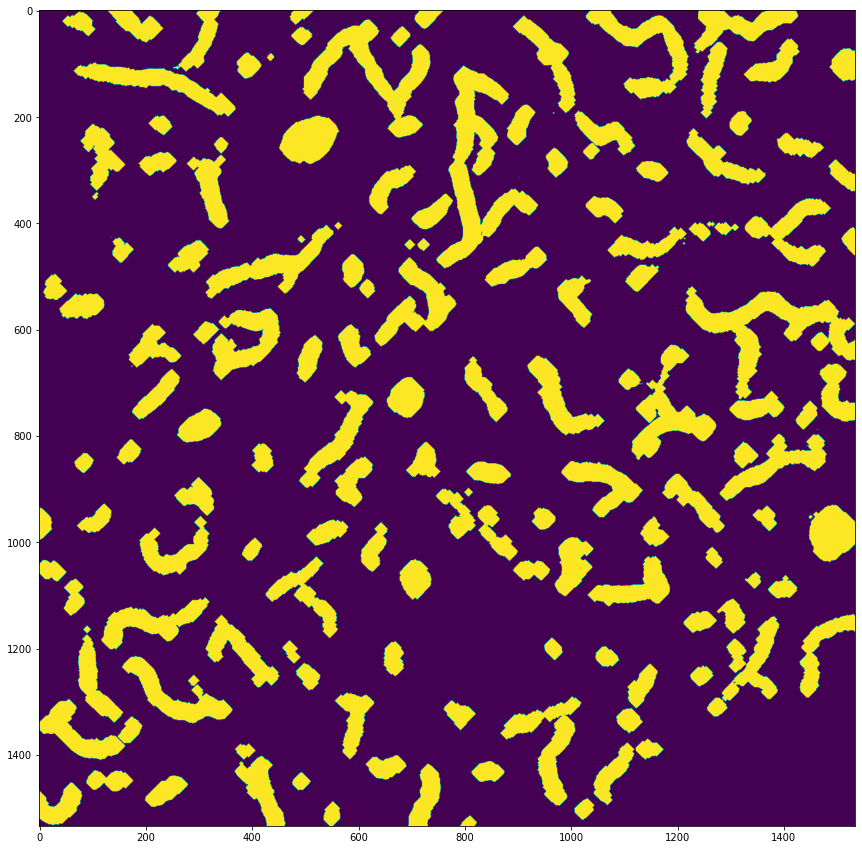

In [23]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(np.max(seg2[:,:,700:750],axis=2))

In [24]:
img_lab, N = cc3d.connected_components(seg2,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
len(counts)

177

In [25]:
sorted(counts)

[33759,
 34231,
 34328,
 34818,
 34951,
 35323,
 37003,
 37023,
 37169,
 37562,
 37675,
 38812,
 39033,
 39545,
 39551,
 39875,
 40017,
 40151,
 40170,
 40391,
 40539,
 40939,
 41192,
 41280,
 41764,
 41827,
 42107,
 42213,
 42221,
 42236,
 42241,
 42814,
 42841,
 42858,
 42960,
 43513,
 43941,
 44021,
 44744,
 44826,
 45228,
 45625,
 45979,
 45986,
 46593,
 46597,
 46816,
 47106,
 47361,
 47482,
 48357,
 48765,
 49768,
 49771,
 50738,
 50794,
 50814,
 51411,
 51791,
 52252,
 52331,
 52816,
 53087,
 53216,
 53451,
 53575,
 53576,
 54234,
 54583,
 56480,
 56670,
 57601,
 57802,
 57829,
 58285,
 59735,
 60398,
 62752,
 63687,
 64696,
 64923,
 65002,
 65154,
 65410,
 66995,
 67106,
 67641,
 68395,
 68687,
 69547,
 70104,
 70228,
 70329,
 70556,
 70976,
 72964,
 77907,
 80980,
 83920,
 83981,
 86114,
 87232,
 87887,
 88074,
 89667,
 94099,
 94479,
 101276,
 103623,
 104184,
 105449,
 106125,
 106659,
 109809,
 112203,
 114135,
 114888,
 116641,
 117112,
 129759,
 134231,
 134247,
 135613,


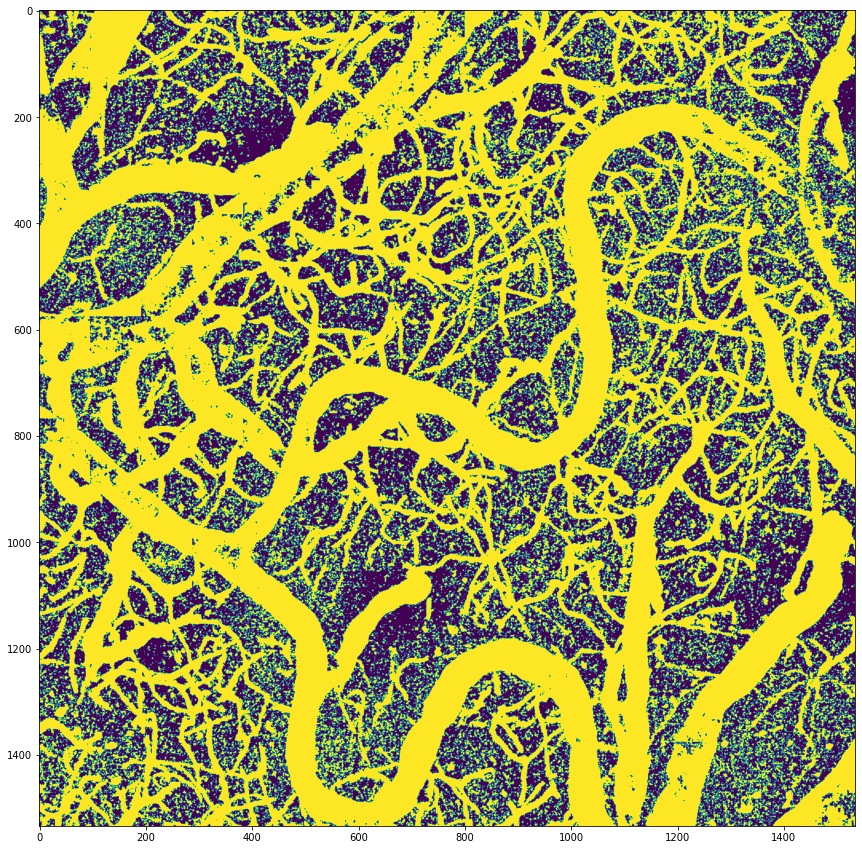

In [26]:
plt.imshow(np.max(img,axis=2))

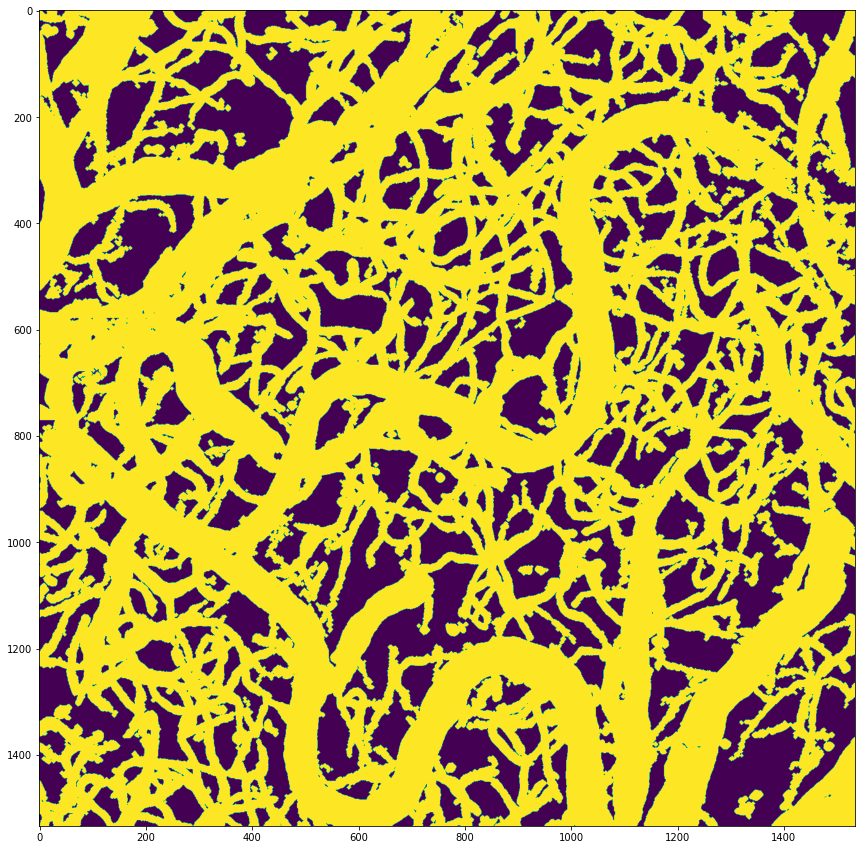

In [27]:
plt.imshow(np.max(segc,axis=2))

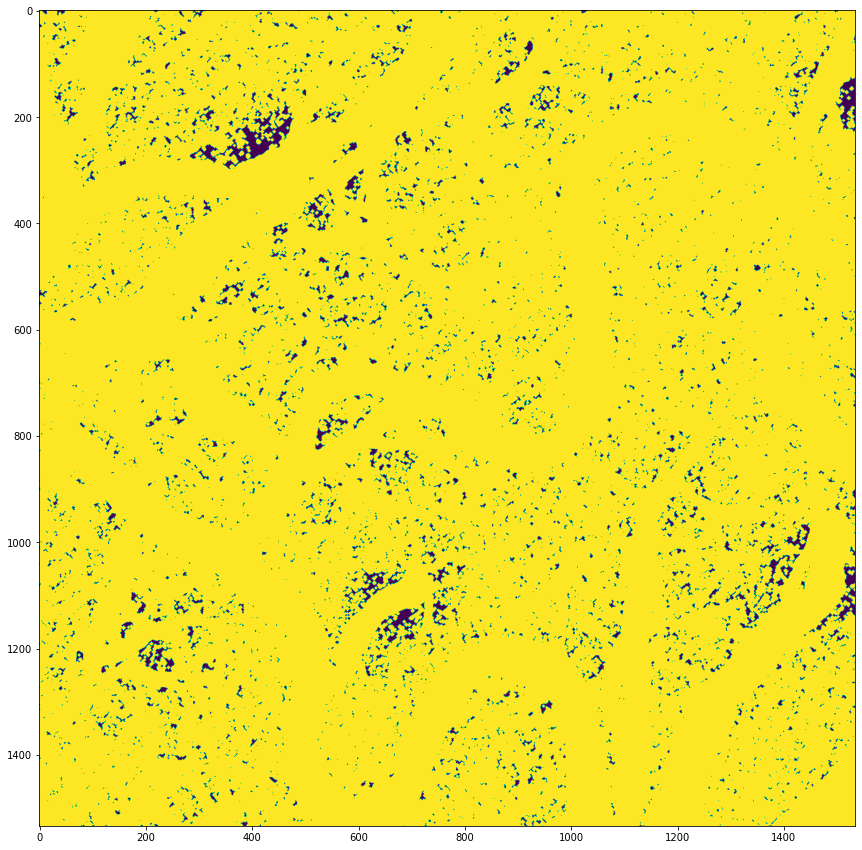

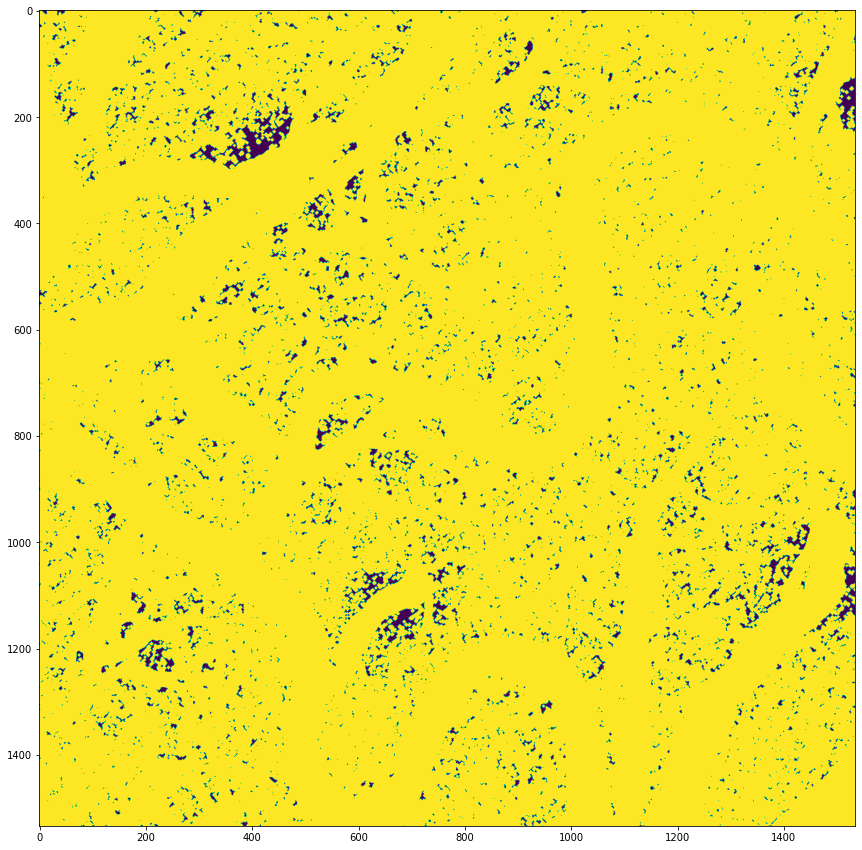

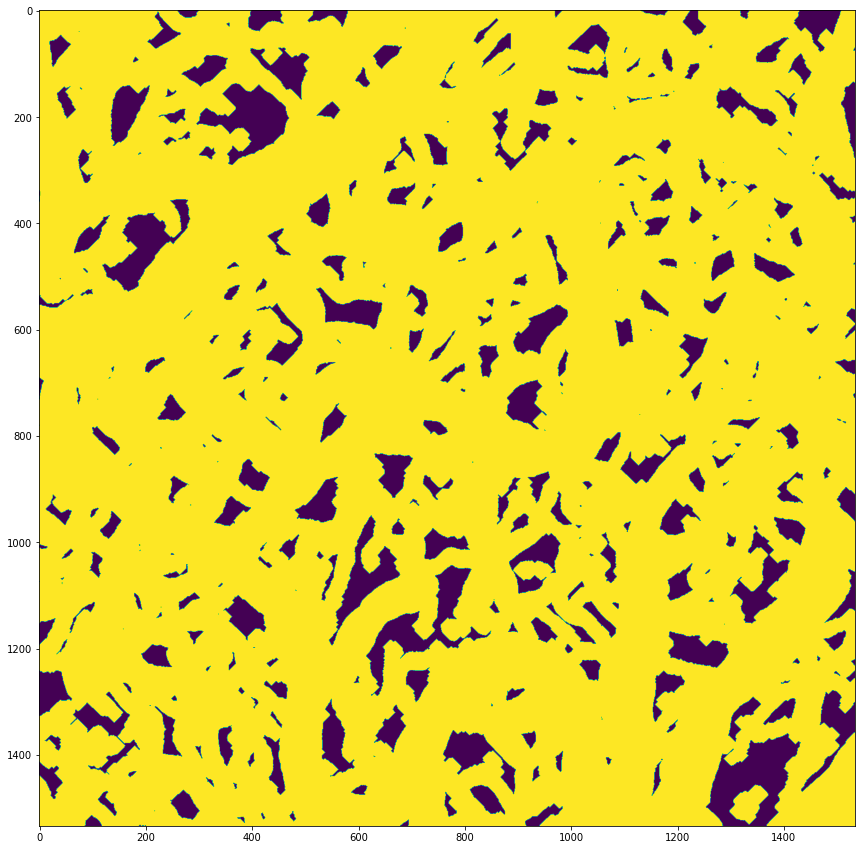

In [28]:
plt.imshow(np.max(seg,axis=2))
plt.show()
plt.imshow(np.max(1-seg1,axis=2))
plt.show()
plt.imshow(np.max(seg2,axis=2))
plt.show()


In [29]:
sorted(counts)[::-1]

[1555556562,
 193545090,
 9001728,
 6463585,
 1383779,
 1344301,
 1267708,
 789384,
 754425,
 717583,
 699329,
 655576,
 578191,
 523261,
 479851,
 460091,
 434295,
 426323,
 361869,
 357995,
 332521,
 323472,
 304755,
 299521,
 285874,
 283701,
 279094,
 276256,
 262393,
 250989,
 248066,
 231815,
 222183,
 217806,
 213955,
 207496,
 207173,
 205049,
 203041,
 202836,
 196276,
 192561,
 192300,
 190158,
 189149,
 170417,
 161877,
 154210,
 146258,
 145052,
 138648,
 138511,
 138019,
 136545,
 135613,
 134247,
 134231,
 129759,
 117112,
 116641,
 114888,
 114135,
 112203,
 109809,
 106659,
 106125,
 105449,
 104184,
 103623,
 101276,
 94479,
 94099,
 89667,
 88074,
 87887,
 87232,
 86114,
 83981,
 83920,
 80980,
 77907,
 72964,
 70976,
 70556,
 70329,
 70228,
 70104,
 69547,
 68687,
 68395,
 67641,
 67106,
 66995,
 65410,
 65154,
 65002,
 64923,
 64696,
 63687,
 62752,
 60398,
 59735,
 58285,
 57829,
 57802,
 57601,
 56670,
 56480,
 54583,
 54234,
 53576,
 53575,
 53451,
 53216,
 53087

In [ ]:
re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image))

# Generate Graphs

In [14]:
directory = Path('matt_raw_warped_upsampled_seg')
files_seg_0001 = directory.glob('*skel*.mat')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
len(files_seg_0001)

1

In [15]:
files_seg_0001[0]
for i in files_seg_0001:
    os.remove(i)

In [ ]:
directory = Path('matt_raw_warped_upsampled_seg')
files_seg_0001 = directory.glob('*_0001_warped_seg.npy')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
np.random.shuffle(files_seg_0001)
len(files_seg_0001)

In [ ]:
for file_0001 in tqdm(files_seg_0001[::-1]):
    #file_0001 = 'matt_raw_warped_upsampled_seg/Feb52021_6-XYZres275_0001_warped_seg.npy'
    #if (time.time() - os.path.getmtime(re.sub('_0001_warped_seg.npy','_warped.pickle',file_0001)))/3600>10:
    if os.path.exists(re.sub('_0001_warped_seg.npy','_skel_warped_single.mat',file_0001)):
        print('yes')
        file = file_0001
        skel_file = re.sub('_0001_warped_seg.npy','_skel_warped_single.mat',file)
        skel = loadmat(skel_file)['FilteredImage']
        if np.sum(skel) != 0:
            io.imsave(re.sub('_0001_warped_seg.npy','_single_skel.tif',file),skel)
            graph = sknw.build_sknw(skel, multi=False)
            print(len(graph.edges))            
            nx.write_gpickle(graph,re.sub('_0001_warped_seg.npy','_warped.pickle',file))
        break

In [ ]:
img_lab, N = cc3d.connected_components(1-skel,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
len(counts)

In [ ]:
plt.imshow(np.max(skel,axis=2).T)
plt.show()

In [ ]:
plt.imshow(np.max(skel,axis=2))
plt.show()

In [ ]:
plt.imshow(skel[:,:,100])
plt.show()

# write vessel measurments to graph files

In [ ]:
directory = Path('matt_preds_registered')
files = directory.glob('*_warped.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if '-' in x]
#files = [x for x in files if not os.path.exists(re.sub('preds','preds_graphs_fwhm',re.sub('.pickle','_radii.pickle',x)))]
print(len(files))
#print(files)

In [ ]:
i=0
min_prob = 0.75
max_var = 0.1
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

for file in tqdm(files[0:]):
    #if not os.path.exists(re.sub('preds','preds_graphs',re.sub('.pickle','_radii.pickle',file))):
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('matt_preds_registered/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1] in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_preds_registered/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name or re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ')[0] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] == re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]]
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            img_file = re.sub('preds_registered','raw_warped',re.sub('_warped.pickle','_warped.tif',file))
                            img_0001_file = re.sub('preds_registered','raw_warped',re.sub('_warped.pickle','_0001_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            seg_0001_file = re.sub('_warped.pickle','_0001_warped_seg.npy',file)
                            mean_file = re.sub('_warped.pickle','_warped_mean.npy',file)
                            mean_0001_file = re.sub('_warped.pickle','_0001_warped_mean.npy',file)
                            std_file = re.sub('_warped.pickle','_warped_std.npy',file)
                            std_0001_file = re.sub('_warped.pickle','_0001_warped_std.npy',file)
                            img = io.imread(img_file)
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1*3,1*3,3*2.645833333))
                            img_0001 = io.imread(img_0001_file)
                            img_0001 = sp.ndimage.zoom(np.swapaxes(img_0001[:,0,:,:],0,2),(1*3,1*3,3*2.645833333))
                            seg = np.load(seg_file)
                            seg_0001 = np.load(seg_0001_file)
                            mean = np.load(mean_file)
                            mean_0001 = np.load(mean_0001_file)
                            std = np.load(std_file)
                            std_0001 = np.load(std_0001_file)
                            seg_dst = distance_transform_edt(seg)
                            seg_0001_dst = distance_transform_edt(seg_0001)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 14'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 15'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                    _pred_radii_max = 5
                                _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii_0001 == 0:
                                    _pred_radii_0001 =1
                                    _pred_radii_max_0001 = 5
                                
                                _box_fit = max([np.int16(_pred_radii_max)+5, np.int16(_pred_radii_max_0001)+5, 10])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),2,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                res_fwhm_0001 = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                break
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points = sp.ndimage.map_coordinates(deconv_img[0]-deconv_img[1],
                                                                        rotated.T, 
                                                                        order=1,
                                                                        cval=-10000)
                                    points_0001 = sp.ndimage.map_coordinates(deconv_img_0001[0]-deconv_img_0001[1],
                                                                             rotated.T, 
                                                                             order=1,
                                                                             cval=-10000)
                                    popt,pcov = sp.optimize.curve_fit(twoD_Gaussian, 
                                                                      xy[0:2, points!=-10000], 
                                                                      points[points!=-10000], 
                                                                      p0=([np.max(points[points!=-10000])-np.mean(points[points!=-10000]),
                                                                           max([_pred_radii, _pred_radii_0001]),
                                                                           0,
                                                                           0,
                                                                           np.mean(points[points!=-10000])]),
                                                                      bounds = ((-1023, 1e-4, -1*_pred_radii/2, -1*_pred_radii/2, -1023), 
                                                                                (1023, max([_pred_radii_max_0001, _pred_radii_max])*5/(2*np.sqrt(2*np.log(2))), _pred_radii/2, _pred_radii/2, 1023)),
                                                                      maxfev=10000
                                                                     )
                                    popt_0001,pcov_0001 = sp.optimize.curve_fit(twoD_Gaussian, 
                                                                                xy[0:2, points_0001!=-10000], 
                                                                                points_0001[points_0001!=-10000], 
                                                                                p0=([np.max(points_0001[points_0001!=-10000])-np.mean(points_0001[points_0001!=-10000]),
                                                                                     max([_pred_radii, _pred_radii_0001]),
                                                                                     0,
                                                                                     0,
                                                                                     np.mean(points_0001[points_0001!=-10000])]),
                                                                                bounds = ((-1023, 1e-4, -1*_pred_radii_0001/2, -1*_pred_radii_0001/2, -1023), 
                                                                                          (1023, max([_pred_radii_max_0001, _pred_radii_max])*5/(2*np.sqrt(2*np.log(2))), _pred_radii_0001/2, _pred_radii_0001/2, 1023)),
                                                                                maxfev=10000
                                                                               )
                                    sigma = popt[1]
                                    fwhm = 2*np.sqrt(2*np.log(2))*sigma
                                    fwhm_sigma = pcov[1,1] * 2*np.sqrt(2*np.log(2))
                                    sigma_0001= popt_0001[1]
                                    fwhm_0001 = 2*np.sqrt(2*np.log(2))*sigma_0001
                                    fwhm_sigma_0001 = pcov_0001[1,1] * 2*np.sqrt(2*np.log(2))
                                    return fwhm, fwhm_0001, fwhm_sigma, fwhm_sigma_0001
                                
                                pool = multiprocessing.Pool(16)
                                _vals, _vals_0001, _vals_sigma, _vals_sigma_0001 = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001'] = np.mean(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001_std'] = np.std(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['delta'] = np.mean(_vals_0001) - np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_0001'] = _vals_0001
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty_0001'] = _vals_sigma_0001
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['img_start_depth'] = start_depth
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['wavelength'] = wavelength
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['power'] = power_per
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            #nx.write_gpickle(graph, re.sub('preds','preds_graphs_fwhm',re.sub('.pickle','_radii.pickle',file)))
        break

In [ ]:
print('here')

In [ ]:
min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    for I in range(len(path)):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points = sp.ndimage.map_coordinates(mean[1],
                                            rotated.T, 
                                            order=1,
                                            cval=-10000)
        points_0001 = sp.ndimage.map_coordinates(mean_0001[1],
                                                 rotated.T, 
                                                 order=1,
                                                 cval=-10000)
        points_std = sp.ndimage.map_coordinates(std[1],
                                            rotated.T, 
                                            order=1,
                                            cval=-10000)
        points_std_0001 = sp.ndimage.map_coordinates(std_0001[1],
                                                 rotated.T, 
                                                 order=1,
                                                 cval=-10000)
        points_img = sp.ndimage.map_coordinates(img,
                                            rotated.T, 
                                            order=1,
                                            cval=-10000)
        points_img_0001 = sp.ndimage.map_coordinates(img_0001,
                                                 rotated.T, 
                                                 order=1,
                                                 cval=-10000)
        
        points = np.reshape(points,(len(X),len(Y)))
        points_std = np.reshape(points_std,(len(X),len(Y)))
        _bin = np.zeros(points.shape)
        _bin[(points > min_prob) * (points_std < max_var)] = 1
        
        points_0001 = np.reshape(points_0001,(len(X),len(Y)))
        points_std_0001 = np.reshape(points_std_0001,(len(X),len(Y)))
        _bin_0001 = np.zeros(points_0001.shape)
        _bin_0001[(points_0001 > min_prob) * (points_std_0001 < max_var)] = 1
        
        img_lab, N = cc3d.connected_components(_bin,return_N=True)
        unique, counts = np.unique(img_lab, return_counts=True)
        img_lab =  np.reshape(img_lab,(len(X),len(Y)))
        cent_val = img_lab[int(img_lab.shape[0]/2),[int(img_lab.shape[1]/2)]][0]
        if cent_val == 0 and np.sum(img_lab) == 0:
            area = 0
            radii = 0
        elif cent_val == 0 and np.sum(img_lab) != 0:
            idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
            cent_val = img_lab[idx[0],idx[1]]
            area = np.sum(img_lab==cent_val)
            radii = np.sqrt(area/np.pi)
        else:
            area = np.sum(img_lab==cent_val)
            radii = np.sqrt(area/np.pi)
        
        img_lab_0001, N_0001 = cc3d.connected_components(_bin_0001,return_N=True)
        unique_0001, counts_0001 = np.unique(img_lab_0001, return_counts=True)
        img_lab_0001 =  np.reshape(img_lab_0001,(len(X),len(Y)))
        cent_val_0001 = img_lab_0001[int(img_lab_0001.shape[0]/2),[int(img_lab_0001.shape[1]/2)]][0]
        if cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
            area_0001 = 0
            radii_0001 = 0
        elif cent_val_0001 == 0 and np.sum(img_lab_0001) != 0:
            idx_0001 = np.argwhere(img_lab_0001)[((np.argwhere(img_lab_0001) - [int(img_lab_0001.shape[0]/2),int(img_lab_0001.shape[1]/2)])**2).sum(1).argmin()]
            cent_val_0001 = img_lab_0001[idx_0001[0],idx_0001[1]]
            area_0001 = np.sum(img_lab_0001==cent_val_0001)
            radii_0001 = np.sqrt(area_0001/np.pi)
        else:
            area_0001 = np.sum(img_lab_0001==cent_val_0001)
            radii_0001 = np.sqrt(area_0001/np.pi)
        
        #print(fwhm)
        #print(I)
        res_fwhm.append(radii)
        res_fwhm_0001.append(radii_0001)
        #res_fwhm_sigma.append(fwhm_sigma)
        #res_fwhm_sigma_0001.append(fwhm_sigma_0001)
        #if I ==5:
        #    break
    plt.plot(res_fwhm)
    plt.plot(res_fwhm_0001)
    plt.show()
    break

In [ ]:
min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    def calc_fwhm_path(I):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points = sp.ndimage.map_coordinates(mean[1],
                                            rotated.T, 
                                            order=3,
                                            cval=-10000)
        points_0001 = sp.ndimage.map_coordinates(mean_0001[1],
                                                 rotated.T, 
                                                 order=3,
                                                 cval=-10000)
        points_std = sp.ndimage.map_coordinates(std[1],
                                            rotated.T, 
                                            order=3,
                                            cval=-10000)
        points_std_0001 = sp.ndimage.map_coordinates(std_0001[1],
                                                 rotated.T, 
                                                 order=3,
                                                 cval=-10000)
        points = np.reshape(points,(len(X),len(Y)))
        points_std = np.reshape(points_std,(len(X),len(Y)))
        _bin = np.zeros(points.shape)
        _bin[(points > min_prob) * (points_std < max_var)] = 1
        
        points_0001 = np.reshape(points_0001,(len(X),len(Y)))
        points_std_0001 = np.reshape(points_std_0001,(len(X),len(Y)))
        _bin_0001 = np.zeros(points_0001.shape)
        _bin_0001[(points_0001 > min_prob) * (points_std_0001 < max_var)] = 1
        
        img_lab, N = cc3d.connected_components(_bin,return_N=True)
        unique, counts = np.unique(img_lab, return_counts=True)
        img_lab =  np.reshape(img_lab,(len(X),len(Y)))
        cent_val = img_lab[int(img_lab.shape[0]/2),[int(img_lab.shape[1]/2)]][0]
        if cent_val == 0 and np.sum(img_lab) == 0:
            area = 0
            radii = 0
        elif cent_val == 0 and np.sum(img_lab) != 0:
            idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
            cent_val = img_lab[idx[0],idx[1]]
            area = np.sum(img_lab==cent_val)
            radii = np.sqrt(area/np.pi)
        else:
            area = np.sum(img_lab==cent_val)
            radii = np.sqrt(area/np.pi)
        
        img_lab_0001, N_0001 = cc3d.connected_components(_bin_0001,return_N=True)
        unique_0001, counts_0001 = np.unique(img_lab_0001, return_counts=True)
        img_lab_0001 =  np.reshape(img_lab_0001,(len(X),len(Y)))
        cent_val_0001 = img_lab_0001[int(img_lab_0001.shape[0]/2),[int(img_lab_0001.shape[1]/2)]][0]
        if cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
            area_0001 = 0
            radii_0001 = 0
        elif cent_val_0001 == 0 and np.sum(img_lab_0001) != 0:
            idx_0001 = np.argwhere(img_lab_0001)[((np.argwhere(img_lab_0001) - [int(img_lab_0001.shape[0]/2),int(img_lab_0001.shape[1]/2)])**2).sum(1).argmin()]
            cent_val_0001 = img_lab_0001[idx_0001[0],idx_0001[1]]
            area_0001 = np.sum(img_lab_0001==cent_val_0001)
            radii_0001 = np.sqrt(area_0001/np.pi)
        else:
            area_0001 = np.sum(img_lab_0001==cent_val_0001)
            radii_0001 = np.sqrt(area_0001/np.pi)
            
        return radii, radii_0001
    
    pool = multiprocessing.Pool(16)
    res_fwhm, res_fwhm_0001,  = zip(*pool.map(calc_fwhm_path, range(len(path))))
    plt.plot(res_fwhm)
    plt.plot(res_fwhm_0001)
    plt.show()

In [ ]:
#plt.plot(res_fwhm)
#plt.plot(res_fwhm_0001)

In [ ]:
plt.imshow(np.reshape(points,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
points = np.reshape(points,(len(X),len(Y)))
points_std = np.reshape(points_std,(len(X),len(Y)))
_bin = np.zeros(points.shape)
_bin[(points > min_prob) * (points_std < max_var)] = 1

In [ ]:
plt.imshow(_bin)

In [ ]:
points_0001 = np.reshape(points_0001,(len(X),len(Y)))
points_std_0001 = np.reshape(points_std_0001,(len(X),len(Y)))
_bin_0001 = np.zeros(points_0001.shape)
_bin_0001[(points_0001 > min_prob) * (points_std_0001 < max_var)] = 1

In [ ]:
plt.imshow(_bin_0001)

In [ ]:
#img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))

In [ ]:
idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
cent_val = img_lab[idx[0],idx[1]]

In [ ]:
img_lab, N = cc3d.connected_components(_bin,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
img_lab =  np.reshape(img_lab,(len(X),len(Y)))
cent_val = img_lab[int(img_lab.shape[0]/2),[int(img_lab.shape[1]/2)]][0]
if cent_val == 0 and np.sum(img_lab) == 0:
    area = 0
    radii = 0
elif cent_val == 0 and np.sum(img_lab) != 0:
    idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
    cent_val = img_lab[idx[0],idx[1]]
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)
else:
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)

In [ ]:
area

In [ ]:
radii

In [ ]:
img_lab_0001, N_0001 = cc3d.connected_components(_bin_0001,return_N=True)
unique_0001, counts_0001 = np.unique(img_lab_0001, return_counts=True)
img_lab_0001 =  np.reshape(img_lab_0001,(len(X),len(Y)))
cent_val_0001 = img_lab_0001[int(img_lab_0001.shape[0]/2),[int(img_lab_0001.shape[1]/2)]][0]
if cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    area_0001 = 0
    radii_0001 = 0
elif cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    idx_0001 = np.argwhere(img_lab_0001)[((np.argwhere(img_lab_0001) - [int(img_lab_0001.shape[0]/2),int(img_lab_0001.shape[1]/2)])**2).sum(1).argmin()]
    cent_val_0001 = img_lab_0001[idx_0001[0],idx_0001[1]]
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)
else:
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)

In [ ]:
radii_0001